## Analyze A/B Test Results



## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)




For this project, I'll will be working to understand the results of an A/B test run by an e-commerce website. The goal is to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

- a look at the data

In [2]:
df = pd.read_csv("ab_data.csv")
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


- number of rows in the dataset.

In [3]:
df.shape[0]

294478

- number of unique users in the dataset.

In [4]:
df["user_id"].nunique()

290584

- The proportion of users converted.

In [5]:
df[df["converted"] == 1]["user_id"].nunique() / df["user_id"].nunique() * 100

12.104245244060237

- number of times the `new_page` and `treatment` don't line up.

In [6]:
len(df[(df["group"] == "treatment") & (df["landing_page"] != "new_page")])

1965

In [7]:
len(df[(df["group"] == "control") & (df["landing_page"] != "old_page")])

1928

In [8]:
# number of total times rows didn't line up for each group
1928 + 1965

3893

- Do any of the rows have missing values?

In [9]:
df.isna().sum()
# No

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

- For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.


In [10]:
# Remove the inaccurate rows, and store the result in a new dataframe df2
df2 = df[(df["group"] == "control") & (df["landing_page"] != "new_page")  | (df["group"] == "treatment") & (df["landing_page"] != "old_page")]

In [11]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

- How many unique **user_id**s are in **df2**?

In [12]:
df2["user_id"].nunique()

290584

- There is one **user_id** repeated in **df2**

In [13]:
df2["user_id"].value_counts()[:2] 
# 773192

773192    2
630836    1
Name: user_id, dtype: int64

- the row information for the repeat **user_id**? 

In [14]:
df2[df2["user_id"] == 773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


- Remove duplicates

In [15]:
df2 = df2.drop(1899)

In [16]:
df2[df2["user_id"] == 773192]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


- What is the probability of an individual converting regardless of the page they receive?

In [17]:
df2[df2["converted"] == 1]['user_id'].nunique() / df2['user_id'].nunique() 
# 0.119597

0.11959708724499628

- Given that an individual was in the `control` group, what is the probability they converted?

In [18]:
ocr = df2[(df2["group"]=="control") & (df2["converted"] == 1)]['user_id'].nunique()  / df2[df2["group"] == "control"]['user_id'].nunique() 
# 0.120399
ocr

0.1203863045004612

- Given that an individual was in the `treatment` group, what is the probability they converted?

In [19]:
ncr = df2[(df2["group"]=="treatment") & (df2["converted"] == 1)]['user_id'].nunique()  / df2[df2["group"] == "treatment"]['user_id'].nunique() 
# 0.118808
ncr

0.11880806551510564

- What is the probability that an individual received the new page?

In [20]:
df2[df2["landing_page"] == "new_page"]["user_id"].nunique() / df2["user_id"].nunique()
# 0.5

0.5000619442226688

In [21]:
obs_diff = ncr - ocr
obs_diff

-0.0015782389853555567

> the obs_diff (conversion rate for new page - conversion rate for old page) was negative which means the conversion rate for the old page was higher (old page gets more conversions) therefore it's better

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

we'll Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>


a. What is the **convert rate** for $p_{new}$ under the null? 

> same as the convert rate for 𝑝𝑜𝑙𝑑 under the null as the null hypothesis says that
> 𝑝𝑛𝑒𝑤 and 𝑝𝑜𝑙𝑑 both have "true" success rates equal to the converted success rate regardless of page 
(0.11959)

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

> same as the convert rate for 𝑝𝑛𝑒𝑤 under the null as the null hypothesis says that
> 𝑝𝑛𝑒𝑤 and 𝑝𝑜𝑙𝑑 both have "true" success rates equal to the converted success rate regardless of page 
> (0.11959)

In [22]:
df2[df2["converted"] == 1]["user_id"].count() / df2["user_id"].count()

0.11959708724499628

- What is $n_{new}$?

In [33]:
n_new = df2[df2["landing_page"] == "new_page"]["user_id"].nunique()
n_new

145310

- What is $n_{old}$?

In [34]:
n_old = df2[df2["landing_page"] == "old_page"]["user_id"].nunique()
n_old

145274

- Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.

In [31]:
new_page_converted = np.random.choice(df2[df2["landing_page"] == "new_page"]["converted"],size=df2.shape[0],replace=True)
p_new = new_page_converted.sum() / (df2[df2["landing_page"] == "new_page"])["user_id"].count()
p_new

0.23550340651021953

- Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.

In [30]:
new_page_converted = np.random.choice(df2[df2["landing_page"] == "old_page"]["converted"],size=df2.shape[0],replace=True)
p_old = new_page_converted.sum() / (df2[df2["landing_page"] == "old_page"])["user_id"].count()
p_old

0.24073130773572698

g. Find $p_{new}$ - $p_{old}$ for simulated values from part (e) and (f).

In [32]:
p_new - p_old

-0.005227901225507453

- Simulate 10,000 $p_{new}$ - $p_{old}$ 

In [82]:
new_con_sam = np.random.binomial(n_new, df2['converted'].mean(), 10000)/ n_new
old_con_sam = np.random.binomial(n_old, df2['converted'].mean(), 10000)/ n_old
p_diffs = new_con_sam - old_con_sam

In [83]:
p_diffs = np.array(p_diffs)

- histogram of the **p_diffs**.  

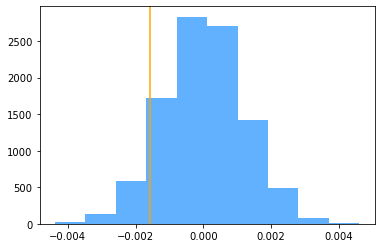

In [84]:
plt.hist(p_diffs,color='dodgerblue',alpha=0.7);
plt.axvline(obs_diff,color="orange");

- proportion of the **p_diffs** 

In [85]:
(p_diffs > obs_diff).mean()

0.9113

- we computed the P value
- there's a difference in the new and old pages
- the mean of the total number of times the p_diffs was actually greater than the the obs_diff from df2

- We could also use a built-in to achieve similar results. 

In [86]:
import statsmodels.api as sm

convert_old = df2[(df2["landing_page"] == "old_page") & (df2["converted"] == 1)]["user_id"].count()
convert_new = df2[(df2["landing_page"] == "new_page") & (df2["converted"] == 1)]["user_id"].count()
n_old = df2[df2["landing_page"] == "old_page"]["user_id"].count()
n_new = df2[df2["landing_page"] == "new_page"]["user_id"].count()

In [87]:
import statsmodels.api as sm
count_array = np.array([convert_new,convert_old])
nobs_array = np.array([n_new,n_old])
z_score, p_value = sm.stats.proportions_ztest(count_array, nobs_array, alternative='larger')
print(z_score, p_value)

-1.3109241984234394 0.9050583127590245


- z-score is less the than mean with 1.310 (1.310 below the mean)
- P value of p_diffs greater than (larger) obs_diff, so we fail to reject the null

<a id='conclusions'></a>
## Conclusions

- Pvalue > P (alpha)
- after this long notebook I bealive that the old page was better

